# Part 1: Import Data and Package Setup

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns, numpy as np
from sklearn.ensemble import IsolationForest
from numpy import genfromtxt
from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score
import io
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

In [3]:
creditcardDF = pd.read_csv(r'C:\Users\a2769\OneDrive\桌面\Python Project\creditcard.csv') #much faster once saved in drive
creditcardDF.head()#all numerical

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Part 2: Data exploration and EDA

In [4]:
#Distribution of the label column
print(creditcardDF['Class'].value_counts())
print("----------------------------------------------------")
print("Extreme inbalanced data with",492 / (284315  + 492))
print("----------------------------------------------------")
print("The data shape is:",creditcardDF.shape)
print("----------------------------------------------------")
print("Check for the Null value")
print(creditcardDF.isna().sum())

0    284315
1       492
Name: Class, dtype: int64
----------------------------------------------------
Extreme inbalanced data with 0.001727485630620034
----------------------------------------------------
The data shape is: (284807, 31)
----------------------------------------------------
Check for the Null value
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


D:\Jupter Notebook\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Time', ylabel='Density'>

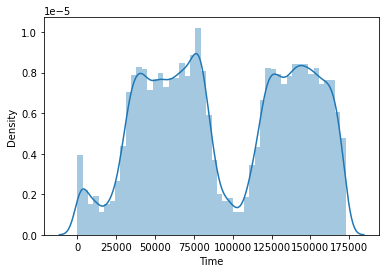

In [5]:
sns.distplot(creditcardDF['Time'])

D:\Jupter Notebook\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Amount', ylabel='Density'>

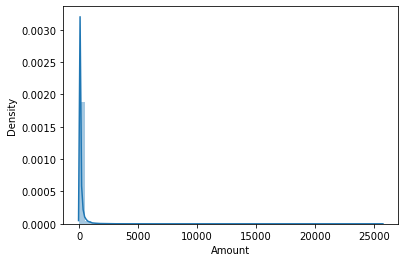

In [6]:
sns.distplot(creditcardDF['Amount'])

# Part 3: Data Transformation

## 2.1 Log the columns of "Amount" and "Time"

In [7]:
#Log the columns of "Amount" and "Time"
creditcardDF['Amount'] = np.log(creditcardDF['Amount'] + 1)
creditcardDF['Time'] = np.log(creditcardDF['Time'] + 1)

# Part 4: Makeup of Train/Validation/Test Data

## 4.1 Separate the Train/Validation/Test Data

In [8]:
#Separate the normal and anomaly
normal = creditcardDF[creditcardDF['Class'] == 0]
anomaly = creditcardDF[creditcardDF['Class'] == 1]

#Separate train,valid,test data
pd.set_option("display.width",1000)
train, small_normal = train_test_split(normal, test_size=0.2, random_state=0)
normal_valid, normal_test = train_test_split(small_normal, test_size=0.5, random_state=0)#2000 : 2000 good hd
anomaly_valid, anomaly_test = train_test_split(anomaly, test_size=0.5, random_state=0)#10 : 10 bad hd

# Make up validation and test data by combining the normal and anomaly
train = train.drop(columns = ['Class']).reset_index(drop= True) #no need of label in train data, drop it
validation = pd.concat([normal_valid, anomaly_valid])           #include both good and bad, cross validation data in our text
test = pd.concat([normal_test, anomaly_test])                   #include both good and bad

## 4.2 Get a glance of data

In [ ]:
#Get a glance of data shape
print("Shape of train data",train.shape)
print("Shape of validation data",validation.shape)
print("Shape of test data",test.shape)

In [51]:
# Get feature names only for Validation and Test dataset, no label
featureNames = list(train.columns.values)
valFeatures = validation[featureNames].reset_index(drop= True)
testFeatures = test[featureNames].reset_index(drop= True)

# Get label only for Validation and Test dataset
valLabel = validation['Class']
testLabel = test['Class']

In [52]:
valFeatures.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,11.827043,-0.248023,1.259502,-0.993999,-1.587788,1.913462,-0.630270,1.958852,-0.659274,0.002373,...,0.396605,0.089915,0.896611,-0.367547,0.143515,-0.177558,0.025269,0.271419,-0.066416,0.920283
1,10.809566,-1.614505,-0.970137,1.730517,-1.715497,-0.869271,-0.171355,1.216768,-0.031314,0.992762,...,0.831753,0.408654,0.630537,0.382848,-0.110627,0.906539,-0.618206,-0.026364,0.104561,5.874931
2,11.340380,1.106176,0.148096,0.424489,1.282916,-0.080275,0.146526,-0.007108,0.114953,-0.004731,...,-0.148073,-0.042488,0.071593,-0.085294,0.032780,0.637894,-0.331179,0.036130,0.007639,2.866193
3,11.321208,-1.791995,1.102738,0.324217,1.082267,-0.303348,-1.050303,0.066270,0.613586,-0.720545,...,-0.285331,0.151935,0.514245,0.290932,0.403345,-0.064118,-0.318054,0.021940,0.013401,3.432373
4,11.956784,1.924286,0.324362,-0.734639,3.370481,0.783552,1.224944,-0.298881,0.291717,-0.790152,...,-0.227395,-0.022543,-0.115448,0.143200,-0.357497,-0.109288,-0.105516,-0.025440,-0.050761,2.572612


## 4.3 Check Imbalanced for validation and test data

In [53]:
# Check Imbalanced for validation and test data
print("Imbalanced for validation data:")
print(validation['Class'].value_counts())
print("----------------------------------------------------")
print("Imbalanced for test data:")
print(test['Class'].value_counts())

Imbalanced for validation data:
0    28431
1      246
Name: Class, dtype: int64
----------------------------------------------------
Imbalanced for test data:
0    28432
1      246
Name: Class, dtype: int64


## 4.4 Plot train/validation/test data

### Plot the V1 and V2 for train data

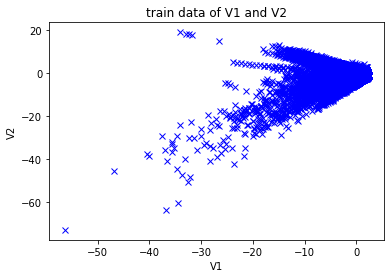

In [55]:
plt.figure()
plt.title("train data of V1 and V2")#may contain outliers
plt.xlabel("V1")
plt.ylabel("V2")
plt.plot(train.iloc[:, 1],train.iloc[:,2],"bx")
plt.show()

### Plot the V1 and V2 for validation data

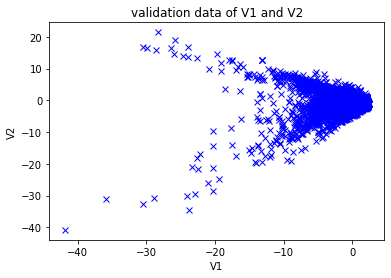

In [56]:
plt.figure()
plt.title("validation data of V1 and V2")
plt.xlabel("V1")
plt.ylabel("V2")
plt.plot(validation.iloc[:, 1],validation.iloc[:,2],"bx")
plt.show()

### Plot the V1 and V2 for test data

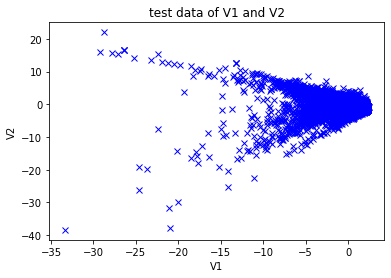

In [57]:
plt.figure()
plt.title("test data of V1 and V2")
plt.xlabel("V1")
plt.ylabel("V2")
plt.plot(test.iloc[:, 1],test.iloc[:,2],"bx")
plt.show()

## Part 5: Using Validation dataset to find the best threshold

### 5.1 Create a function for generating mean for each variable and covariance matrixs for the probability_Based model

In [58]:
def estimateGaussian(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.cov(dataset.T)
    return mu, sigma
mu, sigma = estimateGaussian(train)
print(mu.shape,sigma.shape)

### 5.2 Model Training

No I.I.D assumption

Generate The probability density function/curve/surface/model for multivariate_normal given mean and cov 

Allow_singular: Whether to allow a singular covariance matrix. (Default: False); 

Multivariate_normal needs inverse of cov

In [59]:
model = multivariate_normal(mean=mu, cov=sigma, allow_singular = True)#surface hat p(x)

(30,) (30, 30)


In [60]:
#使用已经构建好的模型来预测每个Validation样本的probability 并且简单检查最大值/最小值
# Print the probability for being outliers for each row
pdfVal = model.pdf(valFeatures)
print("Max Prob for being outliers:",max(pdfVal))#too small, can not differentiate
print("Min Prob for being outliers:",min(pdfVal))

# Print the log_probability for being outliers for each row
#Log of the pdf first, then apply to features, to change the magnitude of prob
p_val = model.logpdf(valFeatures)
print("Max Log_Prob for being outliers:",max(p_val))
print("Min Log_Prob for being outliers:",min(p_val))

Max Prob for being outliers: 3.936022689247857e-12
Min Prob for being outliers: 0.0
Max Log_Prob for being outliers: -26.260850372210477
Min Log_Prob for being outliers: -7554.270217704675


### 5.3 Find Optimal Threshold

In [61]:
#step 2:  find optimal threshold: bestThreshold
scores = []
p_val = model.logpdf(valFeatures) #Log of the pdf

thresholds = np.linspace(min(p_val), max(p_val),200) #generate all candidate threshold, epsilon

for threshold in thresholds:
    y_pred = (p_val < threshold).astype(int)# list of 0 and 1
    # calculate recall, precision and f1 for each (truth, pred) pair, corresponding to that threshold
    scores.append([recall_score(valLabel, y_pred),
                 precision_score(valLabel, y_pred),
                 f1_score(valLabel, y_pred, average = "binary")])

scores = np.array(scores)
#maxIndex of the 3rd column (f1_score) 
#193, 
#.ravel return a flattened array
maxIndex = scores[...,2].ravel().argmax()
bestThreshold = thresholds[maxIndex]
print(scores.shape) #each row is a pair of (recall, precision, f1) corresponding to a threshold

D:\Jupter Notebook\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(200, 3)


In [62]:
print(scores[0:5])

[[0.         0.         0.        ]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]]


In [63]:
print("The index for max probability",maxIndex)
print("The threshold producing the best F1 scores",bestThreshold)

The index for max probability 193
The threshold producing the best F1 scores -253.2360071762041


# Part 6: Predict outliers on test data

In [64]:
# Measure the model performance by using test data
y_test_pred_raw = model.logpdf(testFeatures)
y_pred_test = y_test_pred_raw < bestThreshold #这里得到一个True和False的list

f1_score(testLabel, y_pred_test, average = "binary")

0.7401574803149606

In [65]:
#index of predicted outliers in test data
predoutliersTest = np.asarray(np.where(y_pred_test)) #Get the index for all predicted outlier in test data

print("The number of predicted outlier in test data is:",len(predoutliersTest[0]))

The number of predicted outlier in test data is: 262


In [66]:
predoutliersTest

array([[  248,   437,   605,  1007,  1353,  1451,  1462,  1546,  1988,
         2461,  3674,  3928,  4216,  4928,  5144,  5846,  5975,  6022,
         6682,  6706,  6858,  7017,  7138,  8267,  8452,  8611,  8677,
         8936,  8996,  9207,  9443,  9807,  9988, 10263, 10391, 10657,
        11224, 12205, 13539, 13935, 14050, 14573, 14579, 14802, 14869,
        15740, 16061, 16888, 17322, 17663, 19352, 19902, 20680, 20800,
        21748, 22366, 22552, 22859, 23217, 23456, 23742, 24639, 24819,
        25654, 25678, 26035, 27282, 27293, 27314, 27587, 27723, 28117,
        28178, 28396, 28432, 28433, 28434, 28435, 28436, 28437, 28438,
        28440, 28443, 28444, 28445, 28446, 28447, 28449, 28450, 28453,
        28454, 28455, 28456, 28457, 28458, 28459, 28460, 28461, 28462,
        28463, 28464, 28465, 28466, 28467, 28468, 28469, 28470, 28471,
        28472, 28473, 28475, 28479, 28480, 28481, 28482, 28483, 28484,
        28486, 28487, 28490, 28492, 28493, 28494, 28496, 28497, 28498,
      

## 6.1 Outliers identified on test data feature column V1 V2

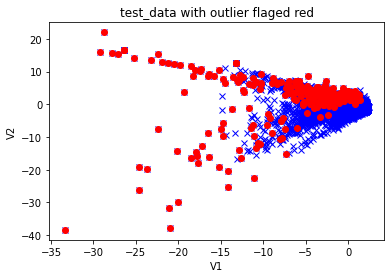

In [67]:
#outliers identified on test data feature column V1 V2
plt.figure()
plt.title("test_data with outlier flaged red")
plt.xlabel("V1")
plt.ylabel("V2")
plt.plot(testFeatures.iloc[:,1],testFeatures.iloc[:,2],"bx")#plot v1 v2 as blue cross
plt.plot(testFeatures.iloc[predoutliersTest[0],1],testFeatures.iloc[predoutliersTest[0],2],"ro")#re-plot the outliers as red dots
plt.show()

## 6.2 Outliers identified on test data feature column V2 V3

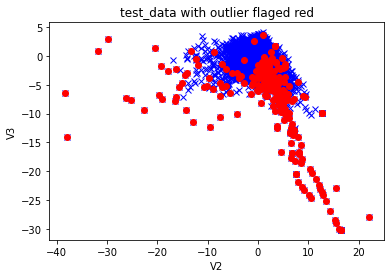

In [68]:
#outliers identified on test data feature column V2 V3
plt.figure()
plt.title("test_data with outlier flaged red")
plt.xlabel("V2")
plt.ylabel("V3")
plt.plot(testFeatures.iloc[:, 2],testFeatures.iloc[:,3],"bx")
plt.plot(testFeatures.iloc[predoutliersTest[0],2],testFeatures.iloc[predoutliersTest[0],3],"ro")
plt.show()

## 6.3 Generate evaluation metrics for outliers

In [69]:
# generate evaluation metrics
print("%s: %r" % ("accuracy_score is: ", accuracy_score(testLabel, y_pred_test)))
print("%s: %r" % ("roc_auc_score is: ", roc_auc_score(testLabel, y_pred_test)))#correction: y_pred_test instead of y_test_pred_raw
print("%s: %r" % ("f1_score is: ", f1_score(testLabel, y_pred_test )))#string to int
print()
print ("confusion_matrix is: ")
cm = confusion_matrix(testLabel, y_pred_test)
cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(cmDF)
print('recall =',float(cm[1,1])/(cm[1,0]+cm[1,1]))
print('precision =', float(cm[1,1])/(cm[1,1] + cm[0,1]))#1.0

accuracy_score is: : 0.9953971685612665
roc_auc_score is: : 0.8808124705473279
f1_score is: : 0.7401574803149606

confusion_matrix is: 
        pred_0  pred_1
true_0   28358      74
true_1      58     188
recall = 0.7642276422764228
precision = 0.7175572519083969


# Part 7: IsolationForest Model

In [ ]:
#note we can apply supervised learning on this data too, but performance may be different, 
#can try use the output prob as an additional input feature of the supervised learning model, and see if it improved the model perf

In [70]:
# Number of estimators: n_estimators refers to the number of base estimators or trees in the ensemble, 
# i.e. the number of trees that will get built in the forest. 
# This is an integer parameter and is optional. The default value is 100.

# Max samples: max_samples is the number of samples to be drawn to train each base estimator. 
# If max_samples is more than the number of samples provided, all samples will be used for all trees. 
# The default value of max_samples is 'auto'. If 'auto', then max_samples=min(256, n_samples)

# Contamination: This is a parameter that the algorithm is quite sensitive to; 
# it refers to the expected proportion of outliers in the data set. 
# This is used when fitting to define the threshold on the scores of the samples. The default value is 'auto'. 
# If ‘auto’, the threshold value will be determined as in the original paper of Isolation Forest.

# Max features: All the base estimators are not trained with all the features available in the dataset. 
# It is the number of features to draw from the total features to train each base estimator or tree.
# The default value of max features is one.

IFModel = IsolationForest(random_state=0, contamination = 0.01, n_estimators = 200, max_features = 2).fit(train)
IFModel

D:\Jupter Notebook\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.01, max_features=2, n_estimators=200,
                random_state=0)

In [72]:
# convert 1/-1 to 0/1 for f1 calculation
def convert(x):
    if x == 1:
        return 0
    else:
        return 1
pred = IFModel.predict(testFeatures) #1 for inliers, -1 for outliers.
pred2 = list(map(convert, pred))

# pred2
import collections

counter=collections.Counter(pred2)
print(counter)#
print("F1 score from IsolationForest model:",f1_score(testLabel, pred2, average = "binary"))

Counter({0: 28283, 1: 395})
F1 score from IsolationForest model: 0.48049921996879874
